(Add description)

In this example we use a pretrained model ('Xception' with 'imagenet' dataset).

## Import dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import pathlib
current_path = pathlib.Path().absolute()
root_path = "{0}/..".format(current_path)
sys.path.append("{0}/src".format(root_path))

import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam

import backbones
#import utils.plots as plots
from train_engine import TrainEngine
from utils import load_dataset, ImageGeneratorConfig, setup_environment

In [2]:
setup_environment(enable_gpu=True)

## Prepare training and evaluation

As we have only few images, we need to augment them to get more input for our neuronal network.

In [3]:
train_files_path = "{0}/img/space_ships/train".format(root_path)
eval_files_path = "{0}/img/space_ships/eval".format(root_path)

input_shape = (138, 256, 3)
generator_config = ImageGeneratorConfig()
generator_config.loop_count = 10
generator_config.horizontal_flip = True
generator_config.zoom_range = 0.5
generator_config.width_shift_range = 0.03
generator_config.height_shift_range = 0.03
generator_config.rotation_range = 180

train_x, train_y, eval_x, eval_y = load_dataset(
    train_files_path, input_shape, validation_split=0.1
)

number_of_classes = 3

Using class indexes as train_y
Split dataset into 18 train and 3 test data


## Create model

In [4]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
base_layers_count = len(base_model.layers)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(number_of_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

optimizer = Adam(lr=0.001)

## Train model

First we will teach the model the new classes.

In [5]:
for layer in base_model.layers:
    layer.trainable = False
    
train_engine = TrainEngine(
    input_shape, 
    model, 
    optimizer, 
    loss="sparse_categorical_crossentropy"
)

### Train

In [6]:
loss, acc, val_loss, val_acc = train_engine.train(
    train_x,
    train_y,
    eval_x,
    eval_y,
    epochs=70,
    batch_size=32,
    image_generator_config=generator_config,
    is_augment_y_enabled=False,
    is_classification=True
)

Epoch 10/70	loss: 0.22376	acc: 0.91	val_loss: 0.11615	val_acc: 0.96667
Epoch 20/70	loss: 0.14381	acc: 0.94528	val_loss: 0.06016	val_acc: 0.98333
Epoch 30/70	loss: 0.11605	acc: 0.95611	val_loss: 0.0486	val_acc: 0.97778
Epoch 40/70	loss: 0.09775	acc: 0.96333	val_loss: 0.03647	val_acc: 0.98333
Epoch 50/70	loss: 0.08484	acc: 0.96867	val_loss: 0.02918	val_acc: 0.98667
Epoch 60/70	loss: 0.08514	acc: 0.96907	val_loss: 0.02462	val_acc: 0.98889
Epoch 70/70	loss: 0.08058	acc: 0.97079	val_loss: 0.02111	val_acc: 0.99048


### Show history

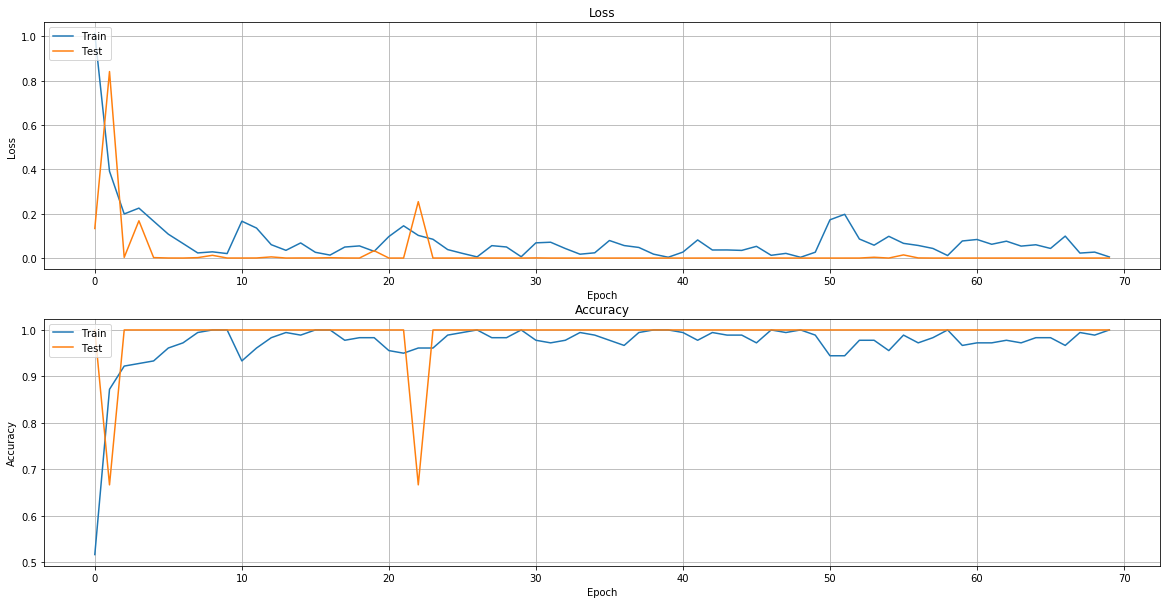

In [7]:
import utils.plots as plots
plots.plot_history(loss, acc, val_loss, val_acc)

Now we fine tune the convolutional layers from the base model.
This will remove connections between neurons that are not used and also create new ones.

In [8]:
for layer in base_model.layers[:base_layers_count]:
    layer.trainable = False
for layer in model.layers[base_layers_count:]:
    layer.trainable = True
    
optimizer = SGD(lr=0.0001, momentum=0.9)

train_engine = TrainEngine(
    input_shape, 
    model, 
    optimizer, 
    loss="sparse_categorical_crossentropy"
)

In [9]:
loss, acc, val_loss, val_acc = train_engine.train(
    train_x,
    train_y,
    eval_x,
    eval_y,
    epochs=20,
    batch_size=32,
    image_generator_config=generator_config,
    is_augment_y_enabled=False,
    is_classification=True
)

Epoch 10/20	loss: 0.0248	acc: 0.99111	val_loss: 2e-05	val_acc: 1.0
Epoch 20/20	loss: 0.03137	acc: 0.98917	val_loss: 2e-05	val_acc: 1.0


## Predict

### Eval dataset we used while training

No classes detected, will continue without classes!
Using train_x as train_y


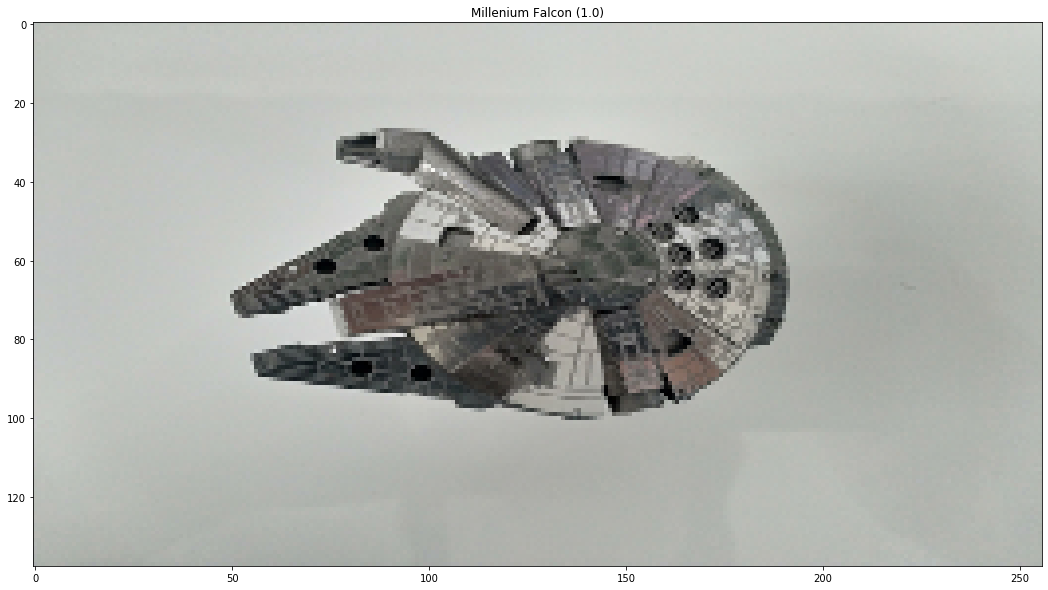

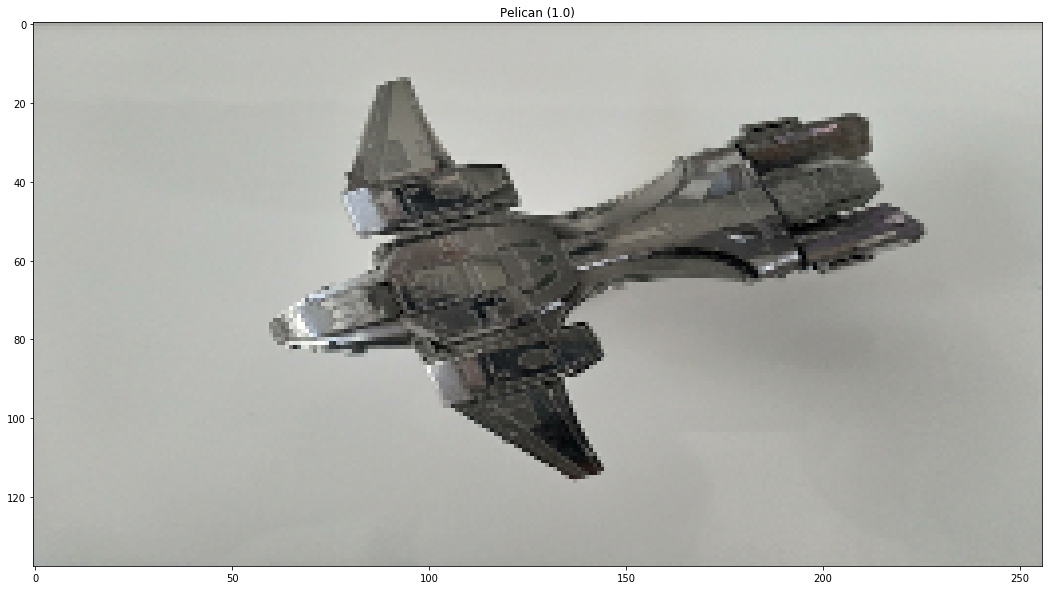

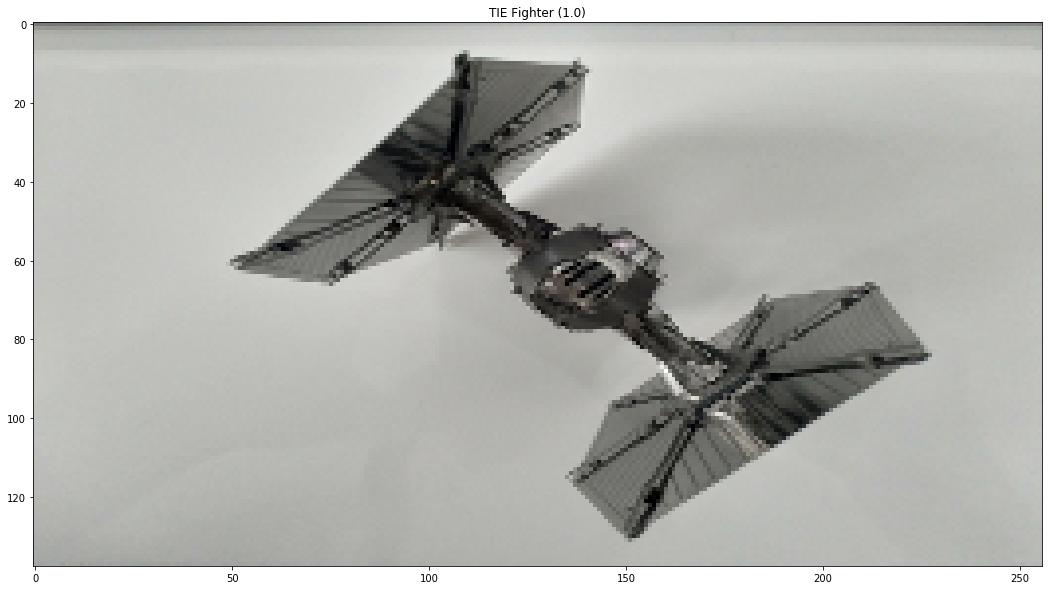

In [10]:
import utils.plots as plots

classes = ['Millenium Falcon', 'Pelican', 'TIE Fighter']

x, _, _, _ = load_dataset(
    eval_files_path, input_shape, validation_split=0
) 

for idx in range(len(x[:3])):
    predictions = train_engine.model.predict(
        np.array([x[idx]], dtype=np.float32), batch_size=1
    )
    plots.plot_classification(predictions, [x[idx]], input_shape, classes)

## Cleanup

In [11]:
K.clear_session()